In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [5]:
def Fake_Spike_Activation_function(r):
    rstate=np.zeros(len(r))
    edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
    for i in range(4):
        for j in np.where(r>=edges[i])[0]:
            rstate[j] = i
    return rstate

In [6]:
def Spike_Time_Generater(r, mean_r, dt, Garmma=1):
    r = r-min(r)
    rdt = r/sum(r)*len(r)*mean_r*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(r)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(r):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

In [7]:
def Poisson_Process_burst(r, mean_r):
    spike_per_burst = 1
    rstate=np.zeros(len(r))
    rdt = r/sum(r)*len(r)*mean_r
    if max(rdt)>=1:
        spike_per_burst = max(rdt)
        rdt = rdt/max(rdt)
    for j in range(len(r)):
        if np.random.rand() <= rdt[j]:
            rstate[j] = np.random.poisson(spike_per_burst)
    return rstate

In [8]:
# activation function
def nA(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

In [9]:
Tot=5000
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

LPOU = ((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))-0.5)*0.1

In [10]:
alpha = 40.
beta = 2.
k = 50.
g = 40.
phi = 1.

k*g*phi/alpha/beta,  beta*k/(alpha*beta+k*g*phi)

(25.0, 0.04807692307692308)

In [11]:
starters = 3000
bright_time = 3000
rest_time = 1000
nstep = rest_time+bright_time+starters
x1 = np.hstack((np.zeros(starters),1*np.ones(bright_time),np.zeros(rest_time)))

LPOU = ((LPOU[:bright_time]-np.mean(LPOU[:bright_time]))/(max(LPOU[:bright_time])-min(LPOU[:bright_time])))*1.3+1
x2 = np.hstack((np.zeros(starters),LPOU,np.zeros(rest_time)))
# noise = (np.random.randn(bright_time))*0.05+1
# x2 = np.hstack((np.zeros(starters),noise,np.zeros(rest_time)))

s1 = np.zeros(nstep)
s2 = np.zeros(nstep)
tau_y = 0.2
T = np.arange(0,int(tau_y/dt*8))*dt
Ky=T/tau_y /tau_y *np.exp(-T/tau_y)
for i in range(len(Ky)-1):
    for ii in range(i+1):
        s1[i] += x1[ii]*Ky[i-ii]*dt
        s2[i] += x2[ii]*Ky[i-ii]*dt
sx = np.convolve(x1[:],Ky,'valid')*dt
s1[len(Ky)-1:] = sx.copy()
sx = np.convolve(x2[:],Ky,'valid')*dt
s2[len(Ky)-1:] = sx.copy()

y1 = np.zeros(nstep)
y2 = np.zeros(nstep)
z1 = np.zeros(nstep)
z2 = np.zeros(nstep)

for i in range(nstep-1):
    dyj1 =(-alpha*y1[i]+k*(s1[i]-z1[i]))*dt
    y1[i+1] = (y1[i]+dyj1)
    dzj1 =(-beta*z1[i]+g*y1[i])*dt
    z1[i+1] = (z1[i]+dzj1)
    
    dyj2 =(-alpha*y2[i]+k*(s2[i]-z2[i]))*dt
    y2[i+1] = (y2[i]+dyj2)
    dzj2 =(-beta*z2[i]+g*y2[i])*dt
    z2[i+1] = (z2[i]+dzj2)

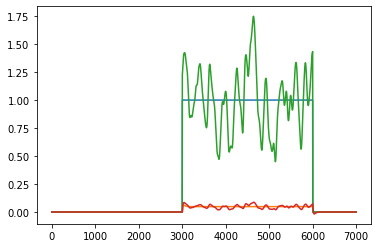

In [12]:
plt.plot(x1)
plt.plot(y1)

plt.plot(x2)
plt.plot(y2)

In [13]:
np.mean(y1[3500:5500]), np.mean(y2[3500:5500])

(0.047918507083041934, 0.045602895555281235)

In [14]:
trial = 500
spike1 = np.zeros((trial, len(y1)))
spike2 = np.zeros((trial, len(y2)))
spike3 = np.zeros((trial, len(y1)))
spike4 = np.zeros((trial, len(y2)))
spike5 = np.zeros((trial, len(y1)))
spike6 = np.zeros((trial, len(y2)))
spike7 = np.zeros((trial, len(y1)))
spike8 = np.zeros((trial, len(y2)))
spike1[0,:] = Fake_Spike_Activation_function( y1)
spike2[0,:] = Fake_Spike_Activation_function( y2)

theta = beta*k/(alpha*beta+k*g*phi)*0.9 #derive from steady state
nA_y1 = nA(y1, theta )
nA_y2 = nA(y2, theta )
for i in np.arange(1,trial):
    spike1[i,:] = np.random.poisson(spike1[0,:])
    spike2[i,:] = np.random.poisson(spike2[0,:])
    
    spike3[i,:] = Poisson_Process_burst(nA_y1, sum(spike1[0,:])/len(spike1[0,:]))
    spike4[i,:] = Poisson_Process_burst(nA_y2, sum(spike2[0,:])/len(spike2[0,:]))
    
    spike_time = Spike_Time_Generater(nA_y1, sum(spike1[0,:])/len(spike1[0,:]), 1)
    spike5[i,:], _ = np.histogram(spike_time, np.arange(0,len(spike1[0,:])+1))
    spike_time = Spike_Time_Generater(nA_y2, sum(spike2[0,:])/len(spike2[0,:]), 1)
    spike6[i,:], _ = np.histogram(spike_time, np.arange(0,len(spike1[0,:])+1))
    
    spike_time = Spike_Time_Generater(nA_y1, sum(spike1[0,:])/len(spike1[0,:]), 1, 5)
    spike7[i,:], _ = np.histogram(spike_time, np.arange(0,len(spike1[0,:])+1))
    spike_time = Spike_Time_Generater(nA_y2, sum(spike2[0,:])/len(spike2[0,:]), 1, 5)
    spike8[i,:], _ = np.histogram(spike_time, np.arange(0,len(spike1[0,:])+1))

## np.random.poisson( Fake_Spike_Activation_function )

0.42711371428571426 ± 0.008092398025055266


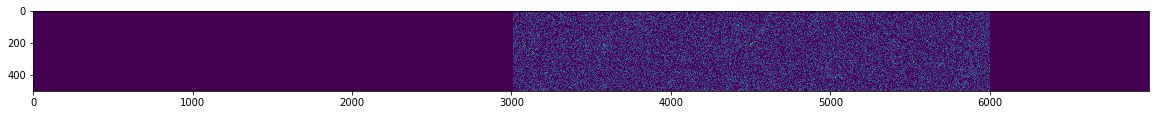

In [15]:
plt.imshow(spike1)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike1, axis=1))/len(spike1[0,:]), u"\u00B1",np.std(np.sum(spike1, axis=1))/len(spike1[0,:]))

In [16]:
index = 5000
np.mean(spike1[:,index]) ,np.var(spike1[:,index])

(0.944, 0.8768639999999998)

0.2587411428571429 ± 0.006067815153306326


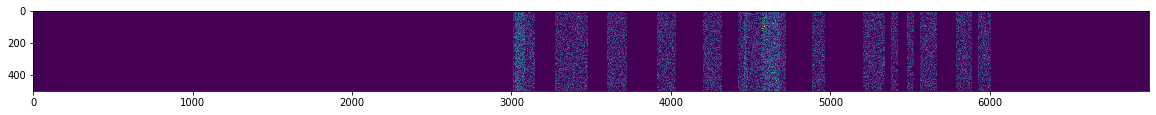

In [17]:
plt.imshow(spike2)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike2, axis=1))/len(spike2[0,:]), u"\u00B1",np.std(np.sum(spike2, axis=1))/len(spike2[0,:]))

## Burst Poisson Process (Spike per bin)

0.4256574285714286 ± 0.024088764251901207


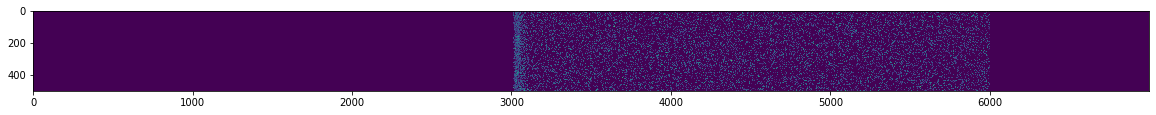

In [18]:
plt.imshow(spike3)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike3, axis=1))/len(spike3[0,:]), u"\u00B1",np.std(np.sum(spike3, axis=1))/len(spike3[0,:]))

In [19]:
index = 3800
np.mean(spike4[:,index]) ,np.var(spike4[:,index])

(0.0, 0.0)

0.25809371428571426 ± 0.01468728845370884


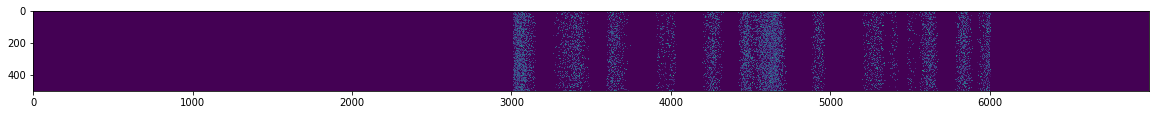

In [20]:
plt.imshow(spike4)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike4, axis=1))/len(spike3[0,:]), u"\u00B1",np.std(np.sum(spike4, axis=1))/len(spike3[0,:]))

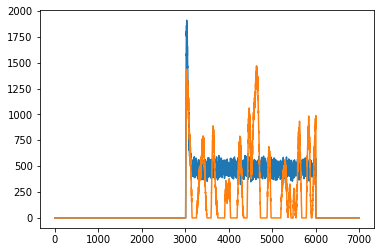

In [21]:
plt.plot(np.sum(spike3, axis=0))
plt.plot(np.sum(spike4, axis=0))

## Poisson Process (Spike Time)

0.42629114285714287 ± 0.02054291305178166


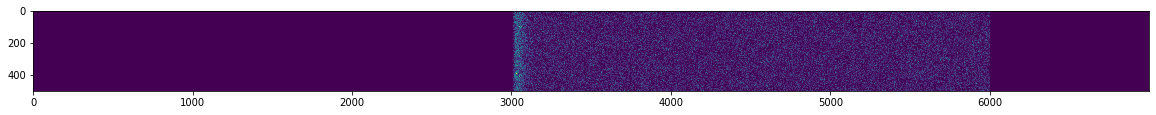

In [22]:
plt.imshow(spike5)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike5, axis=1))/len(spike5[0,:]), u"\u00B1",np.std(np.sum(spike5, axis=1))/len(spike5[0,:]))

In [23]:
index = 4000
nnA_y1 = nA_y1/sum(nA_y1)*len(nA_y1)*sum(spike1[0,:])/len(spike1[0,:])
np.mean(spike5[:,index]) ,np.var(spike5[:,index]), np.mean(nnA_y1[index]), np.sum(nnA_y1)/len(nnA_y1)

(0.914, 0.9266039999999998, 0.9499114463373898, 0.42742857142854923)

0.2583182857142857 ± 0.01304609099011842


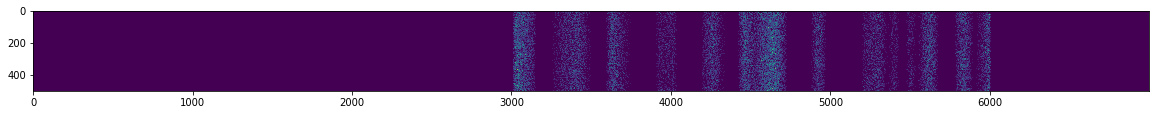

In [24]:
plt.imshow(spike6)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike6, axis=1))/len(spike6[0,:]), u"\u00B1",np.std(np.sum(spike6, axis=1))/len(spike6[0,:]))

In [25]:
index = 3800
nnA_y2 = nA_y2/sum(nA_y2)*len(nA_y2)*sum(spike2[0,:])/len(spike2[0,:])
np.mean(spike6[:,index]) ,np.var(spike6[:,index]), np.mean(nnA_y2[index]), np.sum(nnA_y2)/len(nnA_y2)

(0.0, 0.0, 0.0, 0.25857142857142873)

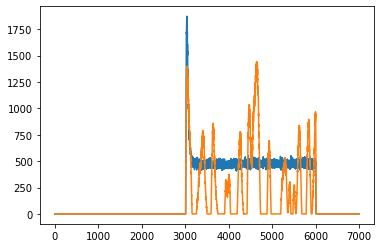

In [26]:
plt.plot(np.sum(spike5, axis=0))
plt.plot(np.sum(spike6, axis=0))

## Poisson Process (Spike Time) (Garmma = 5)

0.42666714285714286 ± 0.01941941018251416


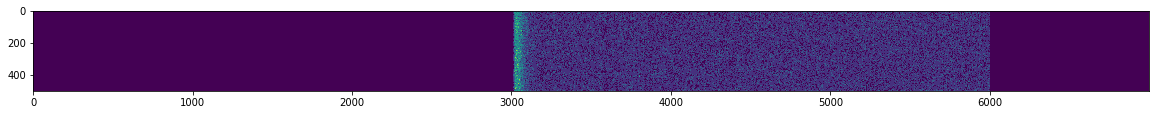

In [27]:
plt.imshow(spike7)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike7, axis=1))/len(spike7[0,:]), u"\u00B1",np.std(np.sum(spike7, axis=1))/len(spike7[0,:]))

In [33]:
index = 4000
nnA_y1 = nA_y1/sum(nA_y1)*len(nA_y1)*sum(spike1[0,:])/len(spike1[0,:])
np.mean(spike7[:,index]) ,np.var(spike7[:,index])*np.sqrt(5), np.mean(nnA_y1[index]), np.sum(nnA_y1)/len(nnA_y1)

(0.962, 0.7525620942354193, 0.9499114463373898, 0.42742857142854923)

0.25805885714285715 ± 0.011850519885263278


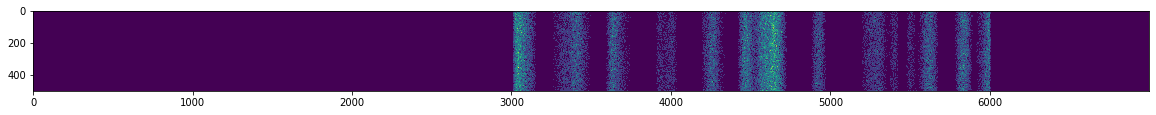

In [29]:
plt.imshow(spike8)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike8, axis=1))/len(spike8[0,:]), u"\u00B1",np.std(np.sum(spike8, axis=1))/len(spike8[0,:]))

In [30]:
index = 3800
nnA_y2 = nA_y2/sum(nA_y2)*len(nA_y2)*sum(spike2[0,:])/len(spike2[0,:])
np.mean(spike8[:,index]) ,np.var(spike8[:,index]), np.mean(nnA_y2[index]), np.sum(nnA_y2)/len(nnA_y2)

(0.0, 0.0, 0.0, 0.25857142857142873)

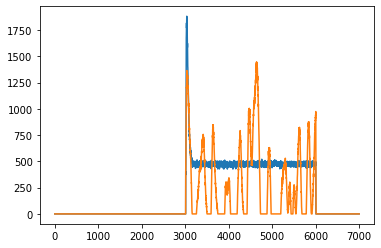

In [31]:
plt.plot(np.sum(spike7, axis=0))
plt.plot(np.sum(spike8, axis=0))

0.1353352832366127